In [2]:
%load_ext autoreload
%autoreload 2

## Objective

Visually, is there a linear, non-linear relationship btwn ea feature and the repsonse? Is the relationship always weak?

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

from transform_for_num_issues_pred import main as transform_dataset

In [21]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style(None)
sns.set_context("paper")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas, adjusted_r2, transform_school

In [3]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [4]:
df_orig = transform_school(df_orig)
df_orig.shape

../preprocessing/helper_functions.py:58: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df.school = df.school.str.extract(r'(\d\d?)').astype(int)


(516406, 40)

In [5]:
df_orig.head(1).T

,905425
CASE_ENQUIRY_ID,101001983786
OPEN_DT,2017-01-07 10:51:37
CLOSED_DT,2017-01-07 11:46:43
TYPE,Request for Snow Plowing
SubmittedPhoto,True
LOCATION_ZIPCODE,2124
Property_Type,Address
LATITUDE,42.2809
LONGITUDE,-71.068
Source,Citizens Connect App


In [6]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(534, 28)

In [7]:
df_transformed.NUM_ISSUES_PER_1000_POP.describe()

count     534.000000
mean      816.807870
std       397.501518
min        36.706869
25%       569.713779
50%       765.916847
75%      1029.902627
max      2939.597315
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

In [8]:
df_transformed.set_index('tract_and_block_group').NUM_ISSUES_PER_1000_POP.sort_values(ascending=False).head(10)

tract_and_block_group
0107021    2939.597315
0404012    2247.452693
0201011    2224.089636
0701011    2094.106464
0703002    2070.548712
0403005    2040.268456
0806013    2038.740920
0703001    1924.330617
0002012    1901.960784
0910013    1847.953216
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

## Dropping more outliers

To see if that improves the model. If so, the next question is, when do we stop removing outliers!?!

In [9]:
more_outliers = ['0107021', '0701011']

In [10]:
df_transformed = df_transformed[~df_transformed.tract_and_block_group.isin(more_outliers)]
df_transformed.shape

(532, 28)

In [11]:
df_transformed.head(1).T

,0
tract_and_block_group,1004002
race_white,0.242399
race_black,0.514358
race_asian,0.035473
race_hispanic,0.0675676
race_other,0.140203
poverty_pop_below_poverty_level,0
earned_income_per_capita,34340
poverty_pop_w_public_assistance,0.0597484
poverty_pop_w_food_stamps,0.138365


## Choosing columns

In [12]:
cols_orig_dataset = ['NUM_ISSUES_PER_1000_POP']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']

In [13]:
df_col_subset = df_transformed[cols_orig_dataset + cols_census]
df_col_subset.shape

(532, 23)

## Dummify

In [14]:
cols_to_dummify = df_col_subset.dtypes[df_col_subset.dtypes == object].index
cols_to_dummify

Index([u'housing'], dtype='object')

In [15]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df_col_subset, cols_to_dummify)

rent is baseline 0 1


In [16]:
df_dummified.shape

(532, 23)

In [17]:
# df_dummified = df_dummified.drop('race_other', axis=1)

## Checking plots

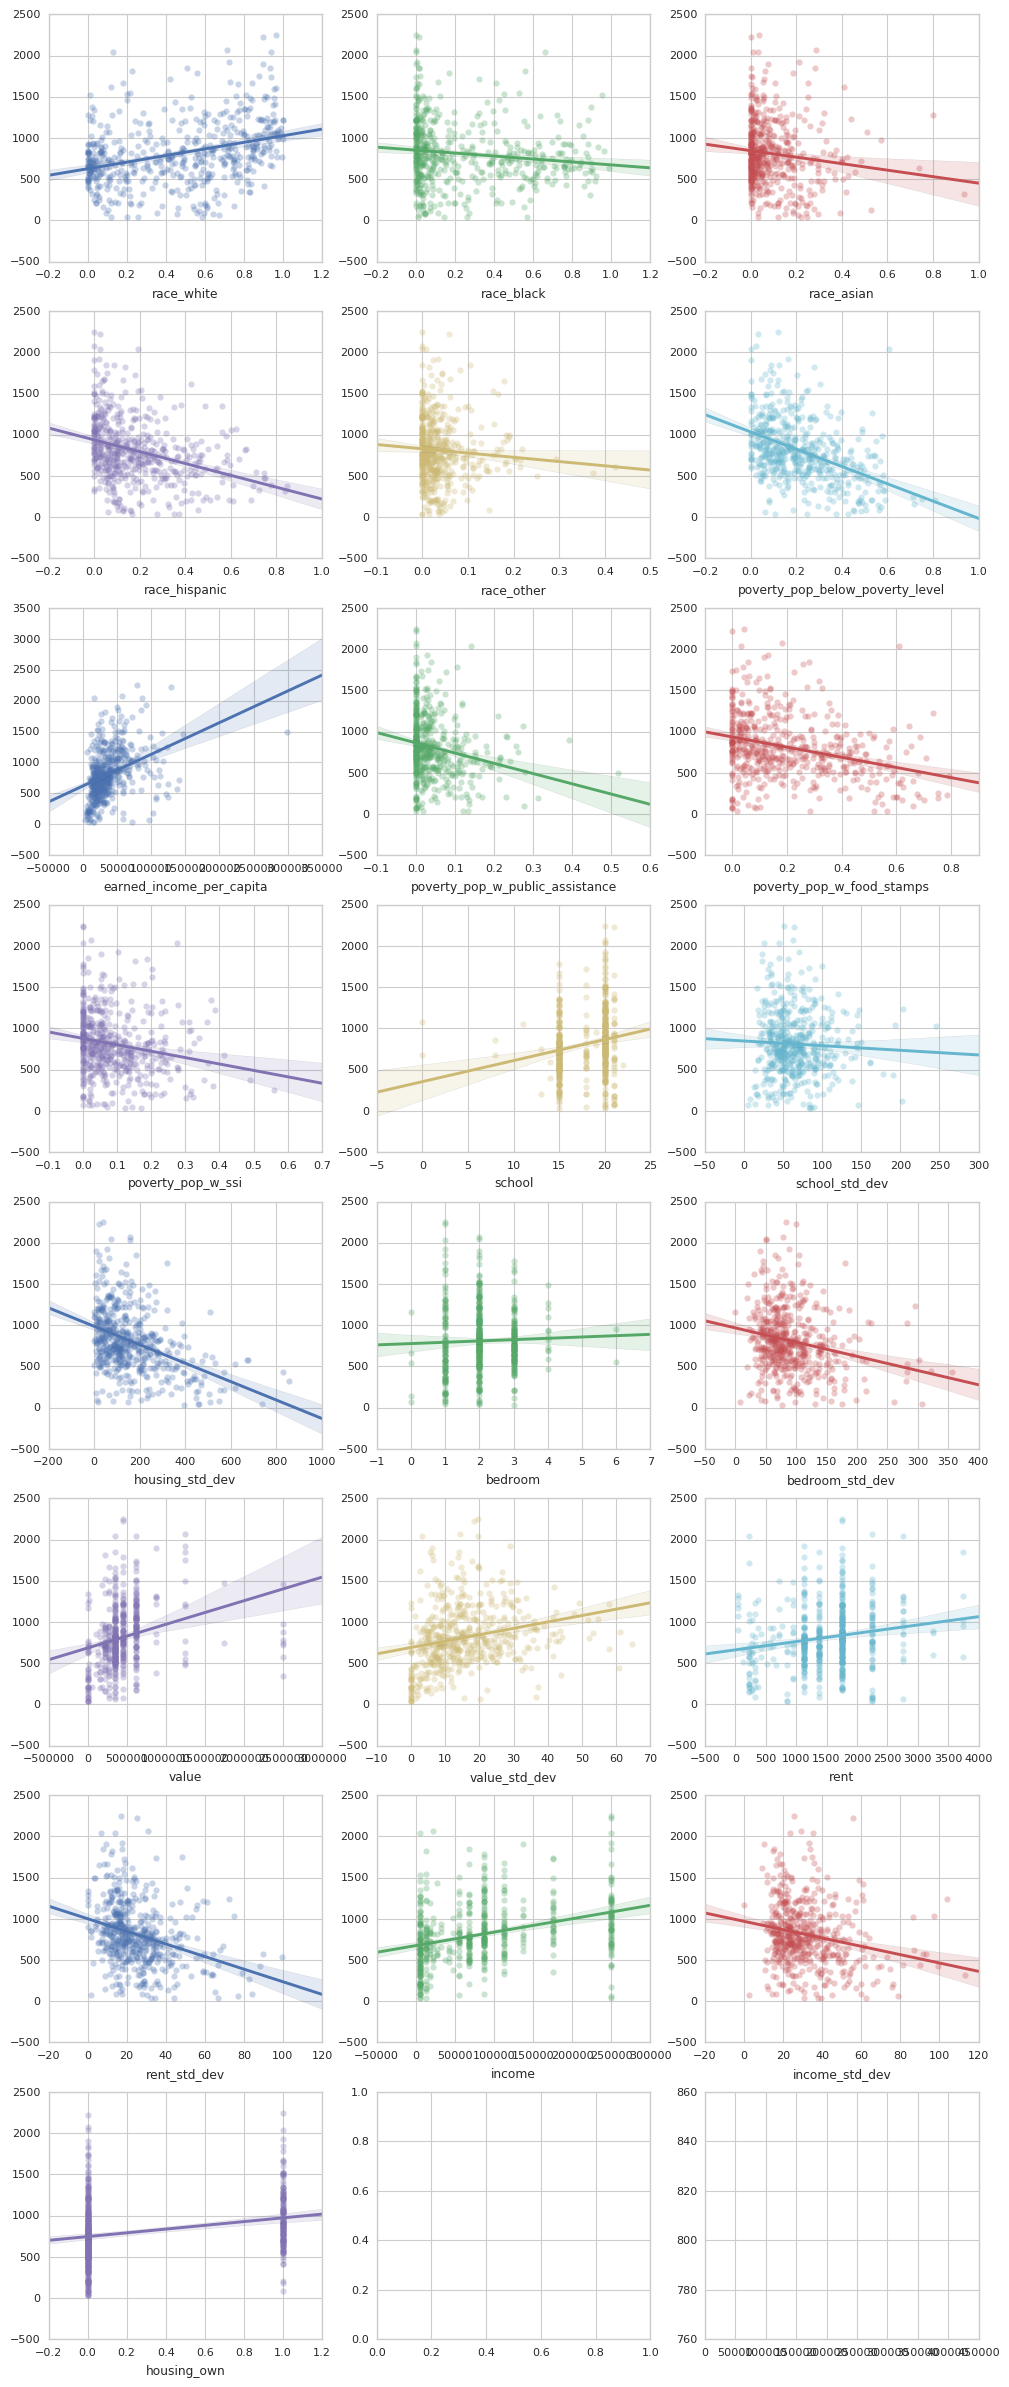

In [23]:
f, ax = plt.subplots(8, 3, figsize=(12,30))

# http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
axs = [item for sublist in ax for item in sublist]

for i, col in enumerate([i for i in df_dummified.columns if i != 'NUM_ISSUES_PER_1000_POP']):
    sns.regplot(df_dummified[col], df_dummified.NUM_ISSUES_PER_1000_POP, ax=axs[i], scatter_kws={'alpha': 0.3})
    axs[i].set_ylabel('')